# Data cleaning of NASDAQ-100 Minute Data and NASDAQ-100 Daily Data

Import libraries

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## NASDAQ-100 Daily data preparation

### Loading the dataset

In [2]:
path = r"NASDAQ-100 Daily Data"  # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['ticker'] = os.path.splitext(os.path.basename(filename))[0]  # Extract ticker from filename
    li.append(df)

daily_data = pd.concat(li, ignore_index=True)

In [3]:
daily_data

,Date,Open,High,Low,Close,Volume,transactions,ticker
0,2015-02-17 05:00:00,31.8725,32.2200,31.730000,31.9575,252516820.0,310744,AAPL
1,2015-02-18 05:00:00,31.9063,32.1950,31.862500,32.1788,179558052.0,226461,AAPL
2,2015-02-19 05:00:00,32.1200,32.2575,32.082500,32.1125,149449524.0,199195,AAPL
3,2015-02-20 05:00:00,32.1550,32.3750,32.012500,32.3738,195793676.0,236741,AAPL
4,2015-02-23 05:00:00,32.5050,33.2500,32.415000,33.2500,283896440.0,340905,AAPL
...,...,...,...,...,...,...,...,...
224025,2025-02-07 05:00:00,207.0200,210.2300,204.420000,205.5300,1476998.0,38798,ZS
224026,2025-02-10 05:00:00,209.2900,212.6900,207.480000,212.5300,1350518.0,32807,ZS
224027,2025-02-11 05:00:00,210.0000,211.3011,207.060000,209.2400,1672527.0,30743,ZS
224028,2025-02-12 05:00:00,206.7700,211.3700,204.640000,211.1400,1363301.0,31255,ZS


Checking if all tickers have the same number of data points. I notice that 70 companies have 2515 data points and then another 2 have one/two missing days. As for the rest there are more missing points. I will further investigate whether this is a data missing issue, or other factor that resulted in the lower datapoints (maybe a company was added to NASDAQ-100 more recently than other companies)

After a quick search ARM (Arm holdings) has joined NASDAQ-100 on June 24 2024, which is why there is only 356 data points. I might consider dropping companies that weren't in NASDAQ-100 for longer period 

In [4]:
daily_data['ticker'].value_counts()

ticker
AAPL    2515
NVDA    2515
MU      2515
MSTR    2515
MSFT    2515
        ... 
META     821
CEG      761
WBD      714
GEHC     530
ARM      356
Name: count, Length: 100, dtype: int64

In [5]:
daily_data['ticker'].value_counts().value_counts().sort_index()

count
356      1
530      1
714      1
761      1
821      1
827      1
1049     1
1050     1
1099     1
1124     1
1338     1
1359     1
1428     1
1575     1
1580     1
1648     1
1660     1
1739     1
1752     1
1840     1
1945     1
2112     1
2308     1
2409     1
2419     1
2482     1
2513     1
2514     3
2515    70
Name: count, dtype: int64

In [6]:
daily_data['Close'].isna().sum()

0

### Quality check of data

Time-related checks:

Missing timestamps

Duplicated timestamps

Irregular intervals

Checking for duplicated dates of tickers

In [7]:
x = 0
for ticker in daily_data['ticker'].unique():
    if daily_data[daily_data['ticker'] == ticker]['Date'].duplicated().any():
        x += 1
print(f"Duplicate dates found for ticker: {x}")

Duplicate dates found for ticker: 0


Checking for irregularity

In [8]:
daily_data['Date'] = pd.to_datetime(daily_data['Date'])


In [9]:
daily_data_aapl = daily_data[daily_data['ticker'] == 'AAPL'].copy()

In [10]:
daily_data_aapl['Date'] = pd.to_datetime(daily_data_aapl['Date'])

In [11]:
daily_data_aapl['Date_diff'] = daily_data_aapl['Date'].diff()

In [12]:
daily_data_aapl['Date_diff'].value_counts()

Date_diff
1 days 00:00:00    1969
3 days 00:00:00     432
4 days 00:00:00      69
2 days 00:00:00      24
2 days 23:00:00      10
3 days 01:00:00      10
Name: count, dtype: int64

In [14]:
daily_data.to_csv('daily_data_cleaned.csv', index=False)

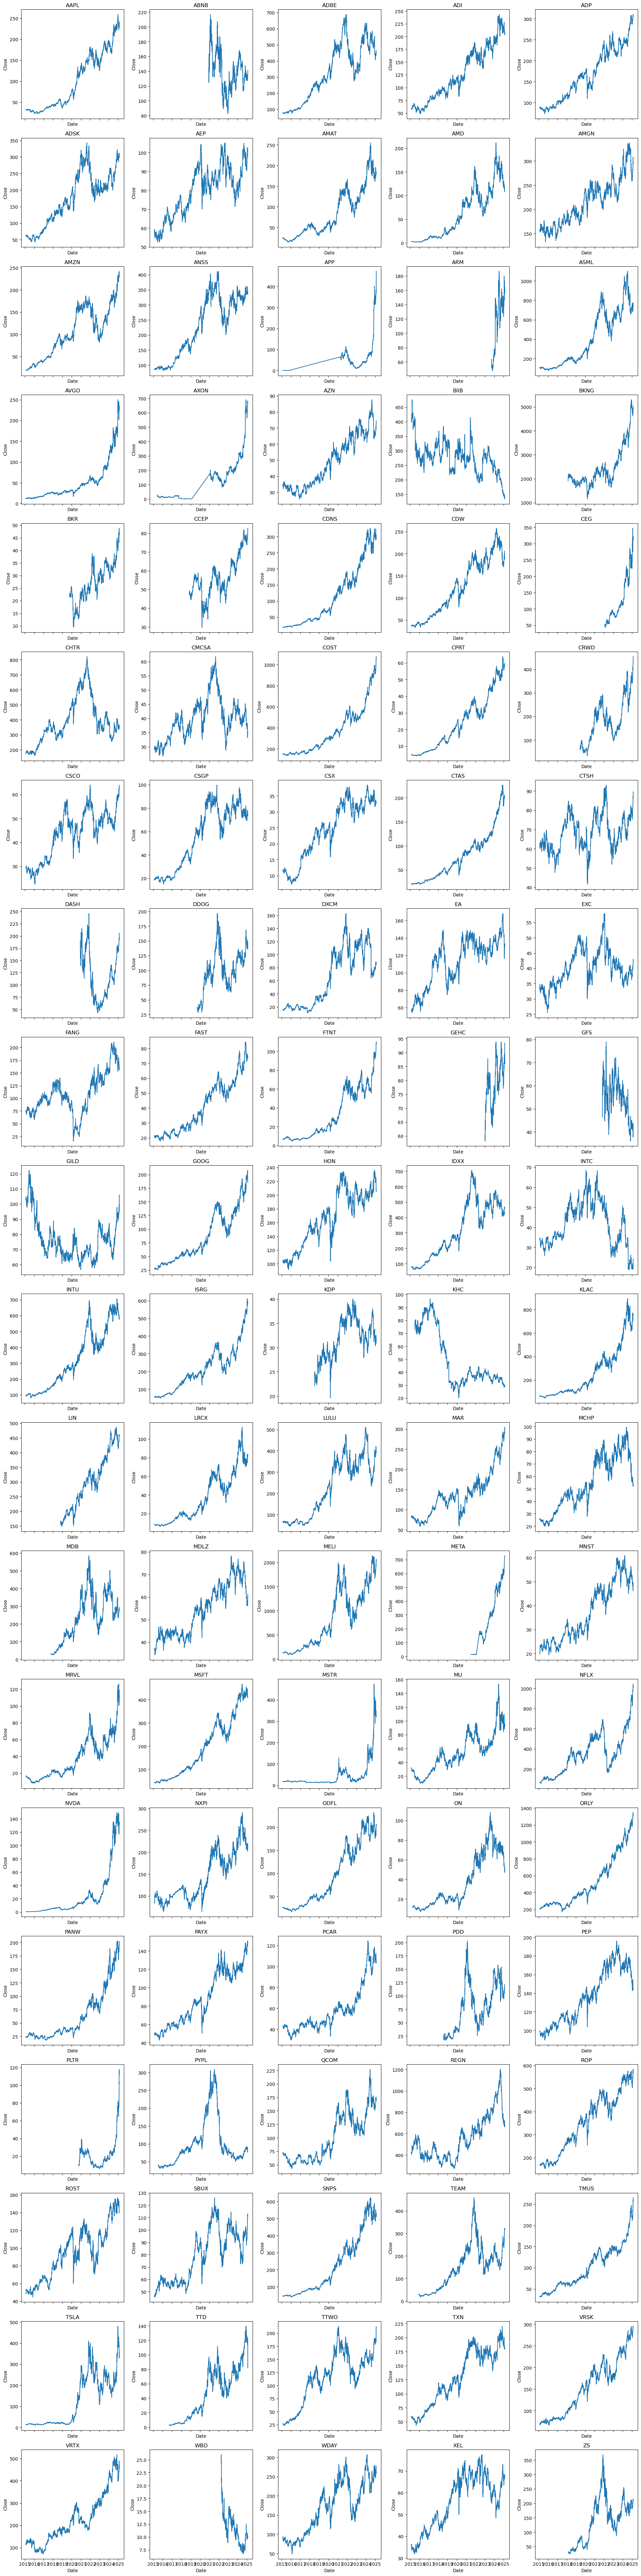

In [128]:
tickers = daily_data['ticker'].unique()
n = len(tickers)
cols = 5
rows = (n // cols) + int(n % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), sharex=True)
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    data = daily_data[daily_data['ticker'] == ticker]
    axes[i].plot(data['Date'], data['Close'])
    axes[i].set_title(ticker)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Close')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [137]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(ticker):
    data = daily_data[daily_data['ticker'] == ticker].copy()
    data.set_index('Date', inplace=True)
    data = data.asfreq('B')  # Ensure business day frequency
    data['Close'].interpolate(method='time', inplace=True)  # Interpolate missing values

    decomposition = seasonal_decompose(data['Close'], model='multiplicative')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    
    plt.tight_layout()
    plt.show()
    

C:\Users\filip\AppData\Local\Temp\ipykernel_13464\3173002654.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Close'].interpolate(method='time', inplace=True)  # Interpolate missing values


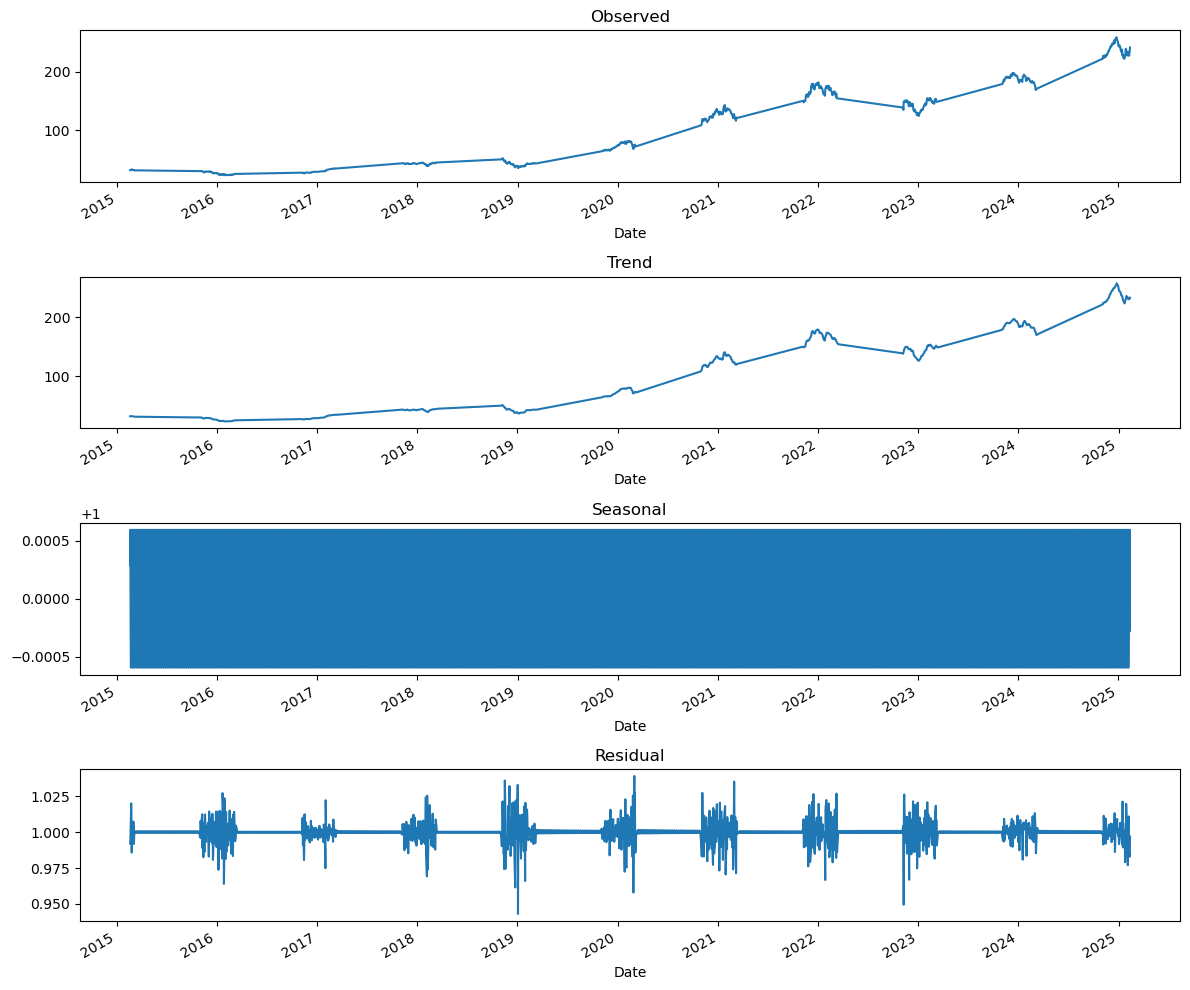

In [138]:
output = plot_seasonal_decomposition('AAPL')

# NASDAQ-100-minute Preparation

## Loading the dataset

In [20]:
path = r"C:\Users\filip\Documents\GitHub\2024-25-y1d-personal-0FilipSarik243537\NASDAQ-100 Minute Data" 
all_files = glob.glob(os.path.join(path, "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['ticker'] = os.path.splitext(os.path.basename(filename))[0]  # Extract ticker from filename
    li.append(df)

minute_data = pd.concat(li, ignore_index=True)

In [36]:
minute_data['Date'] = pd.to_datetime(minute_data['Date'])

In [41]:
minute_data

,Date,Open,High,Low,Close,Volume,Transactions,ticker
0,2015-02-17 09:00:00,31.6500,32.0000,31.6500,32.0000,6176.0,10,AAPL_minute_data
1,2015-02-17 09:01:00,31.7750,31.8375,31.7700,31.7750,3700.0,8,AAPL_minute_data
2,2015-02-17 09:03:00,31.8425,31.8425,31.8425,31.8425,400.0,1,AAPL_minute_data
3,2015-02-17 09:08:00,31.8500,31.8725,31.8500,31.8625,9040.0,14,AAPL_minute_data
4,2015-02-17 09:09:00,31.8500,31.8500,31.8500,31.8500,400.0,1,AAPL_minute_data
...,...,...,...,...,...,...,...,...
52301915,2025-02-10 14:36:00,209.9800,210.0000,209.5100,209.8800,7981.0,162,ZS_minute_data
52301916,2025-02-10 14:37:00,209.9700,210.3300,209.8601,210.0820,12621.0,114,ZS_minute_data
52301917,2025-02-10 14:38:00,210.4115,210.4300,210.0500,210.1500,7275.0,142,ZS_minute_data
52301918,2025-02-10 14:39:00,210.0600,210.0600,209.7200,209.9999,5705.0,115,ZS_minute_data


In [43]:
aapl_data = minute_data[
    (minute_data['ticker'] == 'AAPL_minute_data') &
    (minute_data['Date'].dt.date == pd.to_datetime('2015-02-17').date())
]
aapl_data

,Date,Open,High,Low,Close,Volume,Transactions,ticker
0,2015-02-17 09:00:00,31.6500,32.0000,31.6500,32.0000,6176.0,10,AAPL_minute_data
1,2015-02-17 09:01:00,31.7750,31.8375,31.7700,31.7750,3700.0,8,AAPL_minute_data
2,2015-02-17 09:03:00,31.8425,31.8425,31.8425,31.8425,400.0,1,AAPL_minute_data
3,2015-02-17 09:08:00,31.8500,31.8725,31.8500,31.8625,9040.0,14,AAPL_minute_data
4,2015-02-17 09:09:00,31.8500,31.8500,31.8500,31.8500,400.0,1,AAPL_minute_data
...,...,...,...,...,...,...,...,...
740,2015-02-17 23:51:00,31.9375,31.9375,31.9375,31.9375,5344.0,5,AAPL_minute_data
741,2015-02-17 23:52:00,31.9350,31.9350,31.9350,31.9350,400.0,1,AAPL_minute_data
742,2015-02-17 23:54:00,31.9350,31.9350,31.9350,31.9350,3800.0,3,AAPL_minute_data
743,2015-02-17 23:55:00,31.9325,31.9325,31.9325,31.9325,8060.0,3,AAPL_minute_data


In [ ]:
def fill_missing_minutes(minute_data):
    """
    For each ticker and each trading day, ensure there is a row for every minute between the first and last timestamp.
    Missing minute rows will be added with NaN for price/volume columns.
    """
    # Ensure Date is datetime
    minute_data['Date'] = pd.to_datetime(minute_data['Date'])
    # Extract TradeDate as date
    minute_data['TradeDate'] = minute_data['Date'].dt.date

    filled_frames = []
    for ticker in minute_data['ticker'].unique():
        ticker_df = minute_data[minute_data['ticker'] == ticker]
        for trade_date in ticker_df['TradeDate'].unique():
            day_df = ticker_df[ticker_df['TradeDate'] == trade_date]
            if day_df.empty:
                continue
            start_time = pd.Timestamp(trade_date).replace(hour=day_df['Date'].dt.hour.min(), minute=day_df['Date'].dt.minute.min())
            end_time = pd.Timestamp(trade_date).replace(hour=day_df['Date'].dt.hour.max(), minute=day_df['Date'].dt.minute.max())
            minute_range = pd.date_range(start=start_time, end=end_time, freq='min')
            temp = pd.DataFrame({'Date': minute_range})
            temp['ticker'] = ticker
            merged = pd.merge(temp, day_df, on=['Date', 'ticker'], how='left')
            # Fill TradeDate column
            merged['TradeDate'] = trade_date
            filled_frames.append(merged)
    # Combine all
    if filled_frames:
        return pd.concat(filled_frames, ignore_index=True)
    else:
        # Return empty DataFrame with expected columns
        return pd.DataFrame(columns=minute_data.columns)ch

In [47]:
minute_data = fill_missing_minutes(minute_data)

In [52]:
minute_data.fillna(method='ffill', inplace=True)

C:\Users\filip\AppData\Local\Temp\ipykernel_6720\746877737.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  minute_data.fillna(method='ffill', inplace=True)


In [53]:
minute_data['Date'].isna().sum()

0

In [54]:
minute_data

,Date,ticker,Open,High,Low,Close,Volume,Transactions,TradeDate
0,2015-02-17 09:00:00,AAPL_minute_data,31.6500,32.0000,31.6500,32.0000,6176.0,10.0,2015-02-17
1,2015-02-17 09:01:00,AAPL_minute_data,31.7750,31.8375,31.7700,31.7750,3700.0,8.0,2015-02-17
2,2015-02-17 09:02:00,AAPL_minute_data,31.7750,31.8375,31.7700,31.7750,3700.0,8.0,2015-02-17
3,2015-02-17 09:03:00,AAPL_minute_data,31.8425,31.8425,31.8425,31.8425,400.0,1.0,2015-02-17
4,2015-02-17 09:04:00,AAPL_minute_data,31.8425,31.8425,31.8425,31.8425,400.0,1.0,2015-02-17
...,...,...,...,...,...,...,...,...,...
93426064,2025-02-10 14:42:00,ZS_minute_data,209.7300,209.7400,209.0925,209.3700,2769.0,70.0,2025-02-10
93426065,2025-02-10 14:43:00,ZS_minute_data,209.7300,209.7400,209.0925,209.3700,2769.0,70.0,2025-02-10
93426066,2025-02-10 14:44:00,ZS_minute_data,209.7300,209.7400,209.0925,209.3700,2769.0,70.0,2025-02-10
93426067,2025-02-10 14:45:00,ZS_minute_data,209.7300,209.7400,209.0925,209.3700,2769.0,70.0,2025-02-10


In [55]:
minute_data.to_csv('cleaned_minute_data.csv', index=False)